## Import & Data Load

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from pathlib import Path

train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

In [7]:
### 출력 영상 크기
plt.rcParams["figure.figsize"] = (16,9) # 그림(figure)의 크기. (가로, 세로) 인치 단위
### 출력 영상에 한글 표시
plt.rcParams['font.family'] = "Gulim" # 'AppleGothic' in mac

In [8]:
import seaborn as sns

In [9]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

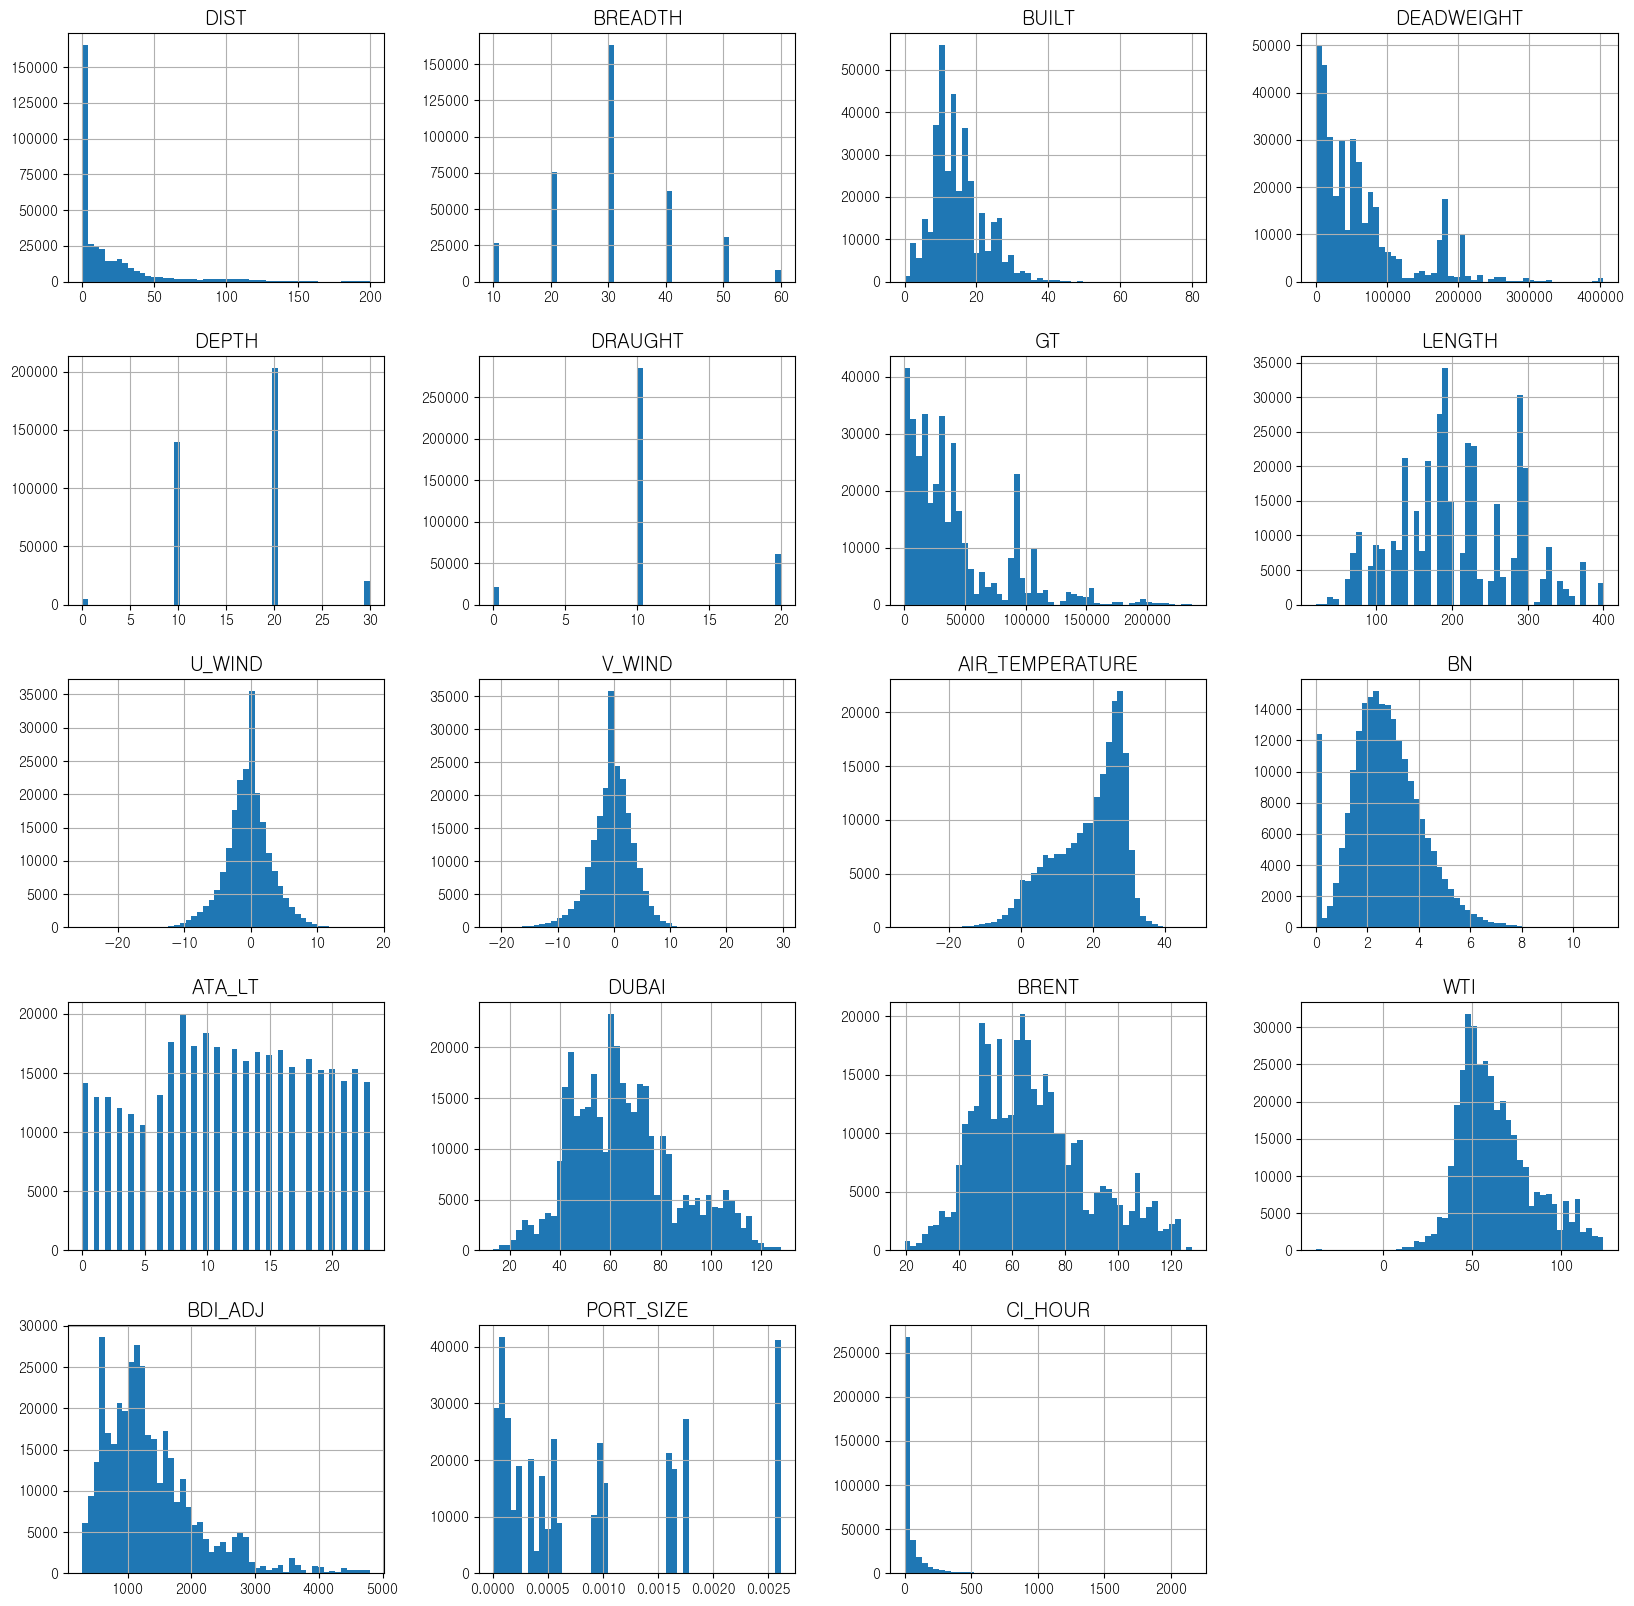

In [10]:
import matplotlib.pyplot as plt

# 추가 코드 – 다음 다섯 라인은 기본 폰트 크기를 지정합니다
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
train.hist(bins=50, figsize=(20, 20))
plt.show()

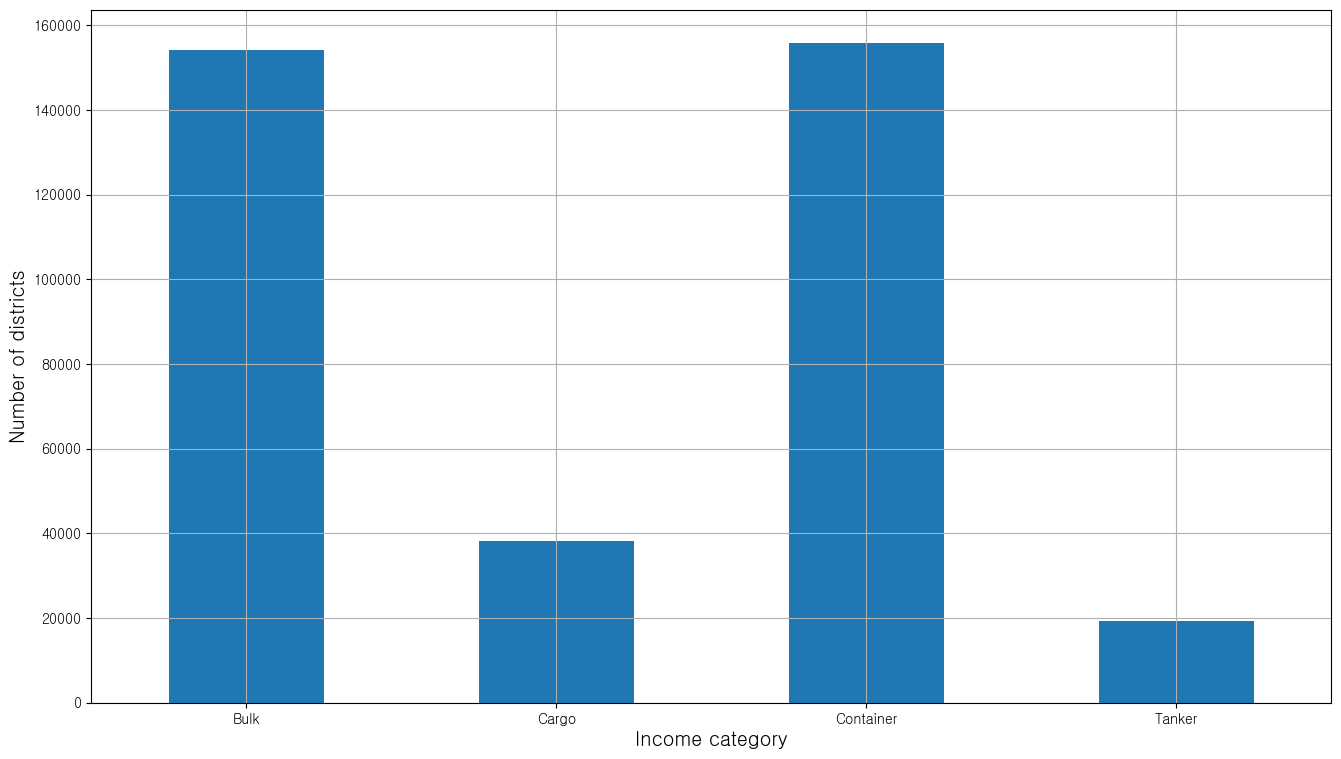

In [11]:
train["SHIP_TYPE_CATEGORY"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [ ]:
train.c

Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ID', 'BREADTH',
       'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
       'ATA_LT', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ', 'PORT_SIZE', 'CI_HOUR',
       'year', 'month', 'day', 'hour', 'minute', 'weekday'],
      dtype='object')

In [ ]:
train[['U_WIND']]

,U_WIND
0,0.140000
1,-3.160000
2,0.000000
3,4.340000
4,1.920000
...,...
367436,-0.297587
367437,-0.060000
367438,-0.630000
367439,3.740000


In [ ]:
train.sort_values(by='CI_HOUR', ascending=False)

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday
97601,8,88,1,41.156698,3350,20.0,22,8550,10.0,10.0,...,59.63,587.239669,0.000264,2159.130556,2015,1,30,9,46,4
162935,17,21,2,0.501433,23947,60.0,8,200000,30.0,20.0,...,60.43,1631.287181,0.002615,2158.901944,2019,4,11,20,56,3
80307,17,21,3,44.993634,17372,60.0,4,319000,30.0,20.0,...,109.56,2053.098389,0.002615,2158.467500,2022,3,19,6,57,5
91032,17,21,2,5.983502,24177,30.0,16,39400,20.0,10.0,...,47.81,830.337728,0.002615,2157.944444,2015,7,9,14,18,3
129768,4,14,2,173.195029,19844,30.0,16,39400,20.0,10.0,...,80.76,2182.034182,0.001614,2157.861389,2021,8,18,7,35,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250459,16,87,0,0.000000,14141,30.0,15,42700,20.0,10.0,...,53.10,554.085164,0.000145,0.000000,2019,2,12,14,36,1
250461,19,13,2,0.000000,17053,30.0,22,23600,10.0,10.0,...,64.00,726.567468,0.000427,0.000000,2019,4,18,4,4,3
113913,8,66,2,0.000000,22627,20.0,11,12700,10.0,10.0,...,52.36,1149.827563,0.000552,0.000000,2019,1,9,22,35,2
113911,17,21,2,0.000000,1600,30.0,10,45300,20.0,10.0,...,52.24,1175.551048,0.002615,0.000000,2017,4,7,6,46,4


In [ ]:
train[['ID']].value_counts()

ID     
E231315    722
J182342    485
X345112    476
W358545    475
T184327    472
          ... 
H137686      1
M414374      1
U648165      1
M414428      1
I516535      1
Name: count, Length: 24764, dtype: int64

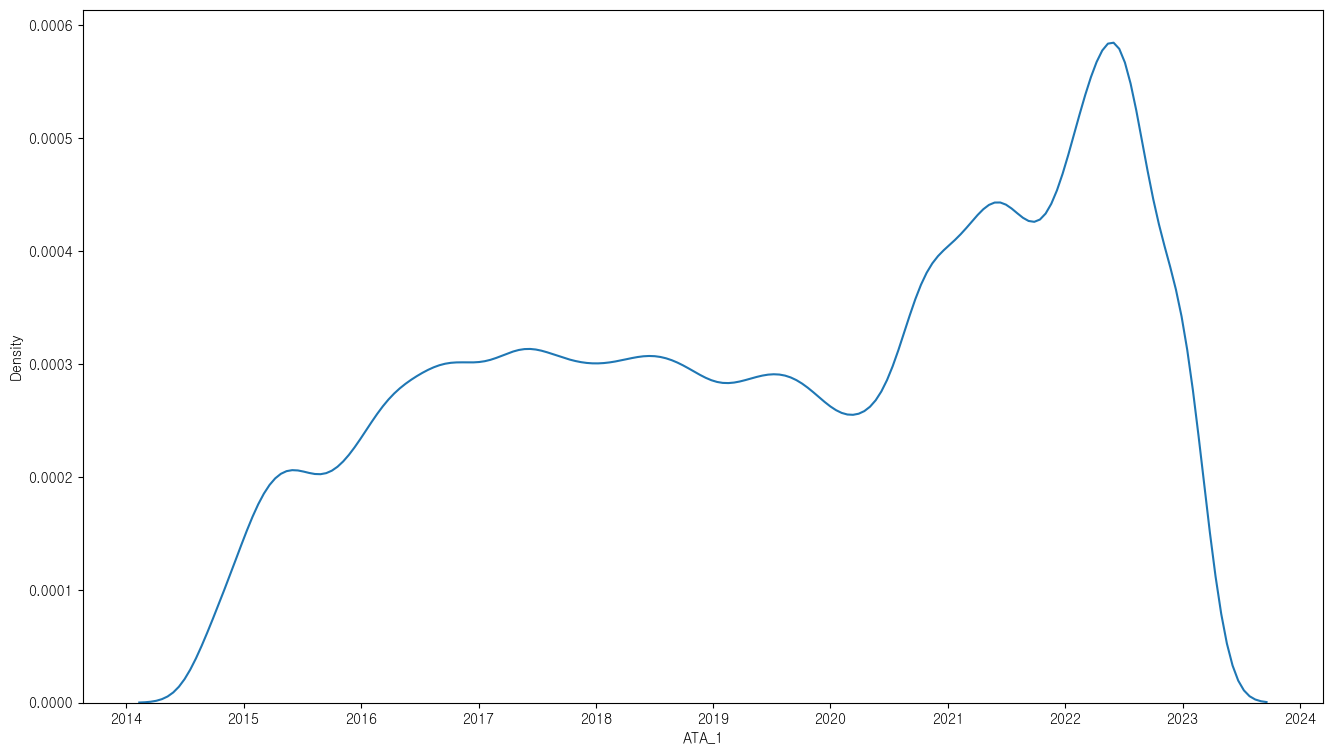

In [ ]:
ATA_plot = sns.kdeplot(train['ATA_1'])
plt.show()

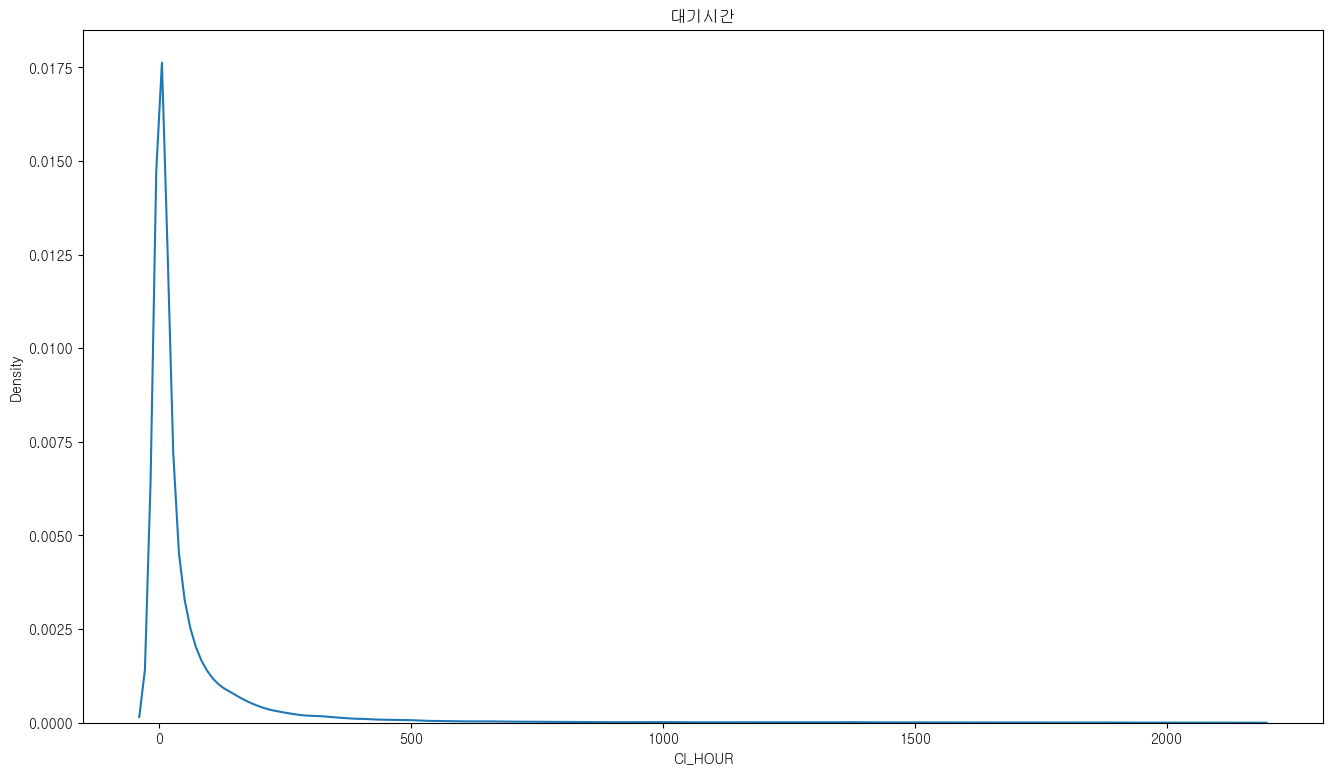

In [ ]:
ATA_plot = sns.kdeplot(train['CI_HOUR'])
plt.title('대기시간')
plt.show()

In [ ]:
CI_HOUR = train.copy()

In [ ]:
corr_matrix = CI_HOUR.corr(numeric_only=True)

In [ ]:
corr_matrix

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday
ARI_CO,1.000000,-0.325793,0.294132,-0.204141,-0.013539,-0.165375,0.103889,-0.262784,-0.165152,-0.192389,...,0.058489,0.033028,0.286965,0.005023,0.064844,-0.014720,-0.001275,0.000866,0.025308,-0.047035
ARI_PO,-0.325793,1.000000,-0.208647,0.003546,0.012500,-0.007914,-0.028150,0.122900,-0.019479,0.051754,...,0.012674,0.015361,-0.443732,0.000110,0.025507,0.013623,0.001312,0.005283,-0.004796,0.028015
SHIP_TYPE_CATEGORY,0.294132,-0.208647,1.000000,0.051261,-0.001476,-0.221137,0.106926,-0.399411,-0.259764,-0.262413,...,0.143051,0.030211,0.511345,-0.087319,0.094655,-0.061656,0.001499,0.001429,0.072627,-0.064203
DIST,-0.204141,0.003546,0.051261,1.000000,-0.001706,0.025656,-0.005212,0.025504,-0.000576,0.031762,...,0.012349,0.021712,0.191062,0.189469,0.018655,-0.018820,0.004247,-0.001057,-0.000021,0.106650
ID,-0.013539,0.012500,-0.001476,-0.001706,1.000000,-0.002787,-0.003286,-0.002894,-0.004144,0.000409,...,-0.000542,-0.005969,-0.010070,-0.008730,-0.005400,-0.000520,0.001664,-0.001010,-0.001151,-0.003211
BREADTH,-0.165375,-0.007914,-0.221137,0.025656,-0.002787,1.000000,-0.209374,0.857015,0.790513,0.761375,...,-0.167848,-0.104851,0.036644,0.043974,-0.198306,0.008739,-0.003263,-0.016303,-0.047790,0.014207
BUILT,0.103889,-0.028150,0.106926,-0.005212,-0.003286,-0.209374,1.000000,-0.240538,-0.206095,-0.146999,...,-0.095918,-0.066262,0.039832,0.001588,-0.121959,0.003180,-0.000553,0.011016,-0.023898,-0.008829
DEADWEIGHT,-0.262784,0.122900,-0.399411,0.025504,-0.002894,0.857015,-0.240538,1.000000,0.712964,0.813259,...,-0.105156,-0.064909,-0.139229,0.078274,-0.131912,0.017555,-0.003341,-0.019731,-0.031128,0.040299
DEPTH,-0.165152,-0.019479,-0.259764,-0.000576,-0.004144,0.790513,-0.206095,0.712964,1.000000,0.581236,...,-0.150480,-0.085423,0.019427,0.052184,-0.169643,0.012445,-0.003460,-0.006324,-0.048243,0.009782
DRAUGHT,-0.192389,0.051754,-0.262413,0.031762,0.000409,0.761375,-0.146999,0.813259,0.581236,1.000000,...,-0.136168,-0.086688,-0.043841,0.040560,-0.161634,0.010244,-0.003855,-0.023575,-0.038003,0.026027


In [ ]:
corr_matrix["CI_HOUR"].sort_values(ascending=False)

CI_HOUR               1.000000
DIST                  0.189469
weekday               0.111973
DEADWEIGHT            0.078274
GT                    0.059959
DEPTH                 0.052184
BREADTH               0.043974
DRAUGHT               0.040560
LENGTH                0.035531
WTI                   0.029377
DUBAI                 0.029129
BRENT                 0.029091
AIR_TEMPERATURE       0.027930
FLAG                  0.021008
year                  0.020975
PORT_SIZE             0.020102
BDI_ADJ               0.019690
V_WIND                0.013866
minute                0.009208
hour                  0.008436
ARI_CO                0.005023
month                 0.003927
SHIPMANAGER           0.002805
BUILT                 0.001588
ARI_PO                0.000110
day                  -0.000032
ATA_LT               -0.000283
ID                   -0.008730
U_WIND               -0.009567
BN                   -0.012957
SHIP_TYPE_CATEGORY   -0.087319
Name: CI_HOUR, dtype: float64

In [ ]:
train.columns

Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ID', 'BREADTH',
       'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
       'ATA_LT', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ', 'PORT_SIZE', 'CI_HOUR',
       'year', 'month', 'day', 'hour', 'minute', 'weekday'],
      dtype='object')

## Data Pre-processing

In [12]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

Encoding features: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]


In [ ]:
train.drop(columns='DUBAI', inplace=True)
test.drop(columns='DUBAI', inplace=True)

In [5]:
train.drop(['DEPTH', 'DRAUGHT', 'BREADTH', 'U_WIND', 'BN'], axis=1 ,inplace=True)
test.drop(['DEPTH', 'DRAUGHT', 'BREADTH', 'U_WIND', 'BN'], axis=1, inplace=True)    

## 모델 학습 및 특성 중요도 확인

Model Tune for LGBM.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


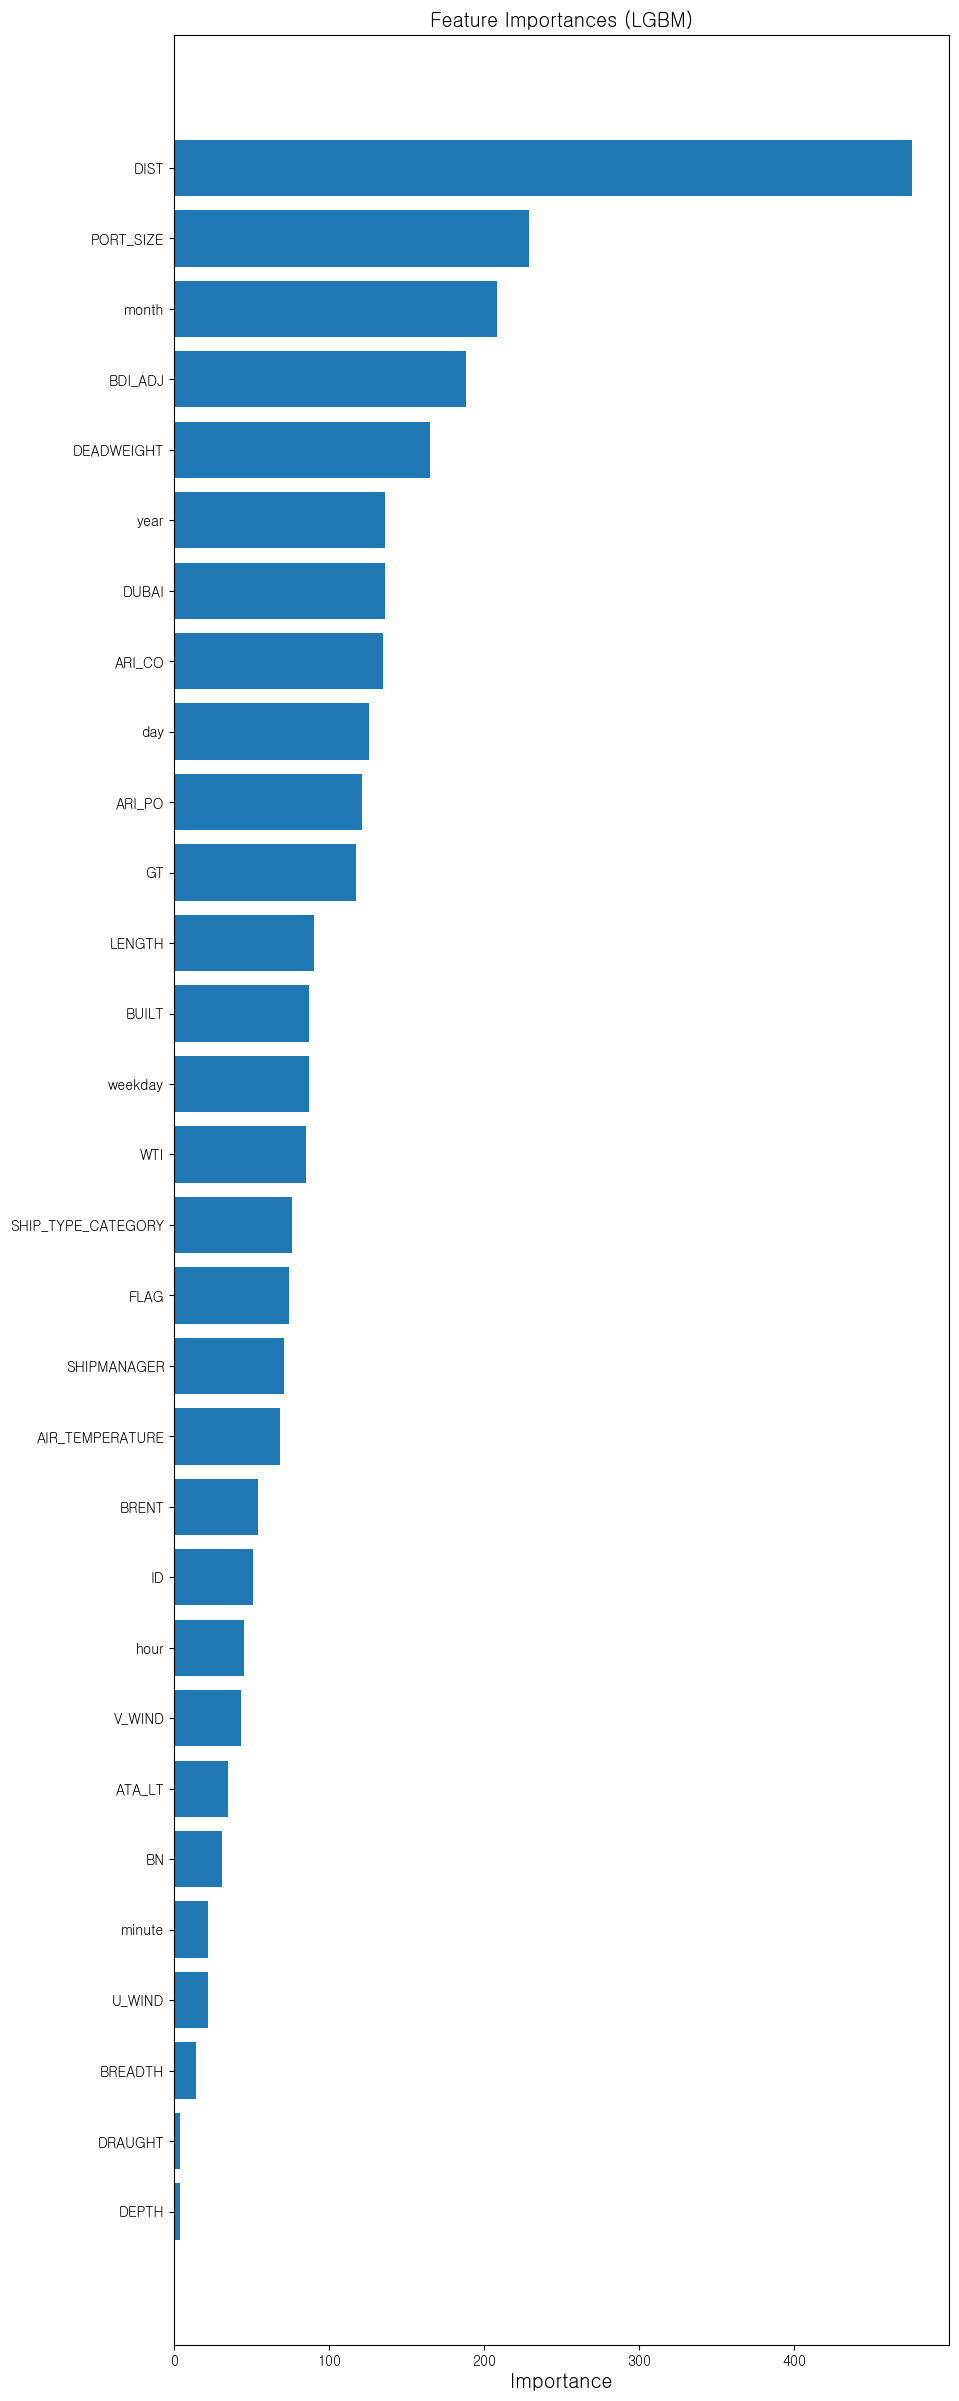

In [13]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

## 특성 중요도로부터 Feature Selection

In [14]:
threshold = 85 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

## K-Fold Model Fitting & Validation

In [15]:
lgbm = lgb.LGBMRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 62.047288


Processing folds:  20%|██        | 1/5 [00:02<00:09,  2.31s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.719969


Processing folds:  40%|████      | 2/5 [00:04<00:06,  2.17s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.754815


Processing folds:  60%|██████    | 3/5 [00:06<00:04,  2.09s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.868218


Processing folds:  80%|████████  | 4/5 [00:08<00:02,  2.11s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.995298


Processing folds: 100%|██████████| 5/5 [00:10<00:00,  2.13s/it]

Validation : MAE scores for each fold: [52.64372300947119, 54.21259302652475, 53.81358286835421, 53.27999456243711, 53.30398273099311]
Validation : MAE: 53.45077523955608


In [17]:
lgbm_pred.shape

(244989,)

In [18]:
final_predictions.shape

(244989,)

## Submission

In [22]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./baseline_submit.csv', index=False)